In [ ]:
import torch
import numpy as np
import argparse
import torch.nn as nn
import torch.nn.functional as F
import re
import torch.optim as optim
import torch.nn.init as initialization
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from itertools import product as cartesian_prod
import random
from scipy import spatial

Constants and Hyperparameters

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Use the Negative Log Likelihood Loss function on the outputs after log_softmax activation
lossFn = nn.BCELoss()

In [ ]:
args={}
kwargs={}

args['input_shape'] = 32*32*3  #Number of features in the input image(of size 28x28)
args['depth'] = 6  #Number of layers in the neural network
args['width']=64  #Number of neurons in each hidden layer
args['batch_size']=32  #Number of samples in each batch
args['epochs']=30  #The number of Epochs is the number of times you go through the full dataset. 
args['lr']=3e-4  #Learning rate is how fast it will decend. 
args['eps']=1e-7  #Epsilon value for Adam

args['cuda']=False  #Use GPU or not


Load the dataset

In [ ]:
mnist_transforms=[
    transforms.ToTensor()
     ]

In [ ]:
trainset = datasets.CIFAR10('../data', train = True, download = True, transform=transforms.Compose(mnist_transforms))

# Selecting classes 0 and 1
y_train = np.array(trainset.targets)
index = np.where(np.in1d(y_train, [0,1]))[0]
y_train = y_train[index]
trainset_01 = torch.utils.data.Subset(trainset, index)

Files already downloaded and verified


In [ ]:
valset = datasets.CIFAR10('../data', train = False, download = True, transform=transforms.Compose(mnist_transforms))

y_val = np.array(valset.targets)
index = np.where(np.in1d(y_val, [0,1]))[0]
y_val = y_val[index]
valset_01 = torch.utils.data.Subset(valset, index)

Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(trainset_01, batch_size=args['batch_size'],
                                          shuffle=True, num_workers=2)

val_loader = torch.utils.data.DataLoader(valset_01, batch_size=args['batch_size'],
                                         shuffle=False, num_workers=2)

In [ ]:
example = iter(train_loader)
data, target = next(example)

Train and test function for the models

In [ ]:
def train(model, epoch, train_loader, lossFn, optimizer):
  model.train()
  loss = 0
  net_loss = 0
  correct = 0
  
  for batch_idx, (data, target) in enumerate(train_loader):
      if args['cuda']:
          data, target = data.cuda(), target.cuda()
      
      #Reshape the input image to 1D vector
      data = data.reshape(-1, args['input_shape']).to(device)
      target = target.to(device)

      #This will zero out the gradients for this batch. 
      optimizer.zero_grad()

      #Run the model on the train data
      output = model(data)
      
      target = target.unsqueeze(1).float()

      # Calculate the loss
      loss = lossFn(output, target)
      net_loss += loss.data

      #dloss/dx for every Variable 
      loss.backward()

      #to do a one-step update on our parameter.
      optimizer.step()
      
      pred = (output > 0.5).float()
      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

      
  #Print out the loss
  print('Train Epoch: {} \tLoss: {:.6f}, Accuracy: {}/{} ({:.0f}%)'.format(
          epoch, net_loss/len(train_loader.dataset), correct, len(train_loader.dataset),
          100. * correct / len(train_loader.dataset)))

def validate(model, validation_loader, lossFn):

  model.eval()
  validation_loss = 0
  correct = 0

  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
    for data, target in validation_loader:
      if args['cuda']:
          data, target = data.cuda(), target.cuda()

      #Reshape the input image to 1D vector
      data = data.reshape(-1, args['input_shape']).to(device)
      target = target.to(device)

      #Run the model on the validation data and get its predictions
      output = model(data)

      target = target.unsqueeze(1).float()

      #Calculate the loss
      validation_loss += lossFn(output, target).data.item()  #sum up batch loss

      pred = (output > 0.5).float()

      correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()  #find the number of correct predictions

  print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      validation_loss/len(validation_loader.dataset), correct, len(validation_loader.dataset),
      100. * correct / len(validation_loader.dataset)))

ReLu network

In [ ]:
class Relu(nn.Module):
  
  def __init__(self, depth, width, input_size):

    super(Relu, self).__init__()
    
    # Get the depth and width of the network
    self.depth = depth
    self.width = width

    #Create the layers with names L1, L2, ... dynamically
    setattr(self,'L1', nn.Linear(input_size, width))
    for i in range(depth - 2):
        setattr(self,'L{}'.format(i+2), nn.Linear(width, width))

    self.output = nn.Linear(width, 1) 

  def forward(self, x, **kwargs):
    Z = F.relu(getattr(self,'L1')(x))  #activations of layer 1

    #Repeat for all layers
    for i in range(self.depth-2):
      Z = F.relu(getattr(self,'L{}'.format(i+2))(Z))

    return F.sigmoid(self.output(Z))   

In [ ]:
#Instantiate the ReLU model
relu_model_without_patch = Relu(args['depth'], args['width'], args['input_shape'])
print(relu_model_without_patch)
print()

if args['cuda']:
    relu_model_without_patch.cuda()

optimizer = optim.Adam(relu_model_without_patch.parameters(), lr=args['lr'], eps=args['eps'])

for epoch in range(1, args['epochs'] + 1):
    train(relu_model_without_patch, epoch, train_loader, lossFn, optimizer)
    validate(relu_model_without_patch, val_loader, lossFn)

Relu(
  (L1): Linear(in_features=3072, out_features=64, bias=True)
  (L2): Linear(in_features=64, out_features=64, bias=True)
  (L3): Linear(in_features=64, out_features=64, bias=True)
  (L4): Linear(in_features=64, out_features=64, bias=True)
  (L5): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

Train Epoch: 1 	Loss: 0.015606, Accuracy: 7380/10000 (74%)

Validation set: Average loss: 0.0108, Accuracy: 1710/2000 (86%)

Train Epoch: 2 	Loss: 0.010831, Accuracy: 8487/10000 (85%)

Validation set: Average loss: 0.0108, Accuracy: 1680/2000 (84%)

Train Epoch: 3 	Loss: 0.010002, Accuracy: 8580/10000 (86%)

Validation set: Average loss: 0.0100, Accuracy: 1745/2000 (87%)

Train Epoch: 4 	Loss: 0.009442, Accuracy: 8618/10000 (86%)

Validation set: Average loss: 0.0085, Accuracy: 1769/2000 (88%)

Train Epoch: 5 	Loss: 0.008581, Accuracy: 8794/10000 (88%)

Validation set: Average loss: 0.0087, Accuracy: 1745/2000 (87%)

Train E

In [ ]:
def get_dataset(loader):
  X = np.empty((0, 28, 28))
  Y = np.empty((0))

  for data, target in loader:
    data = data.reshape(-1, 28, 28)
    X = np.concatenate((X, data.cpu().detach().numpy()), axis=0)
    Y = np.concatenate((Y, target.cpu().detach().numpy()), axis=0)

  return X, Y

In [ ]:
def add_patch(dataset, patch_size=5):

  Y = dataset.targets

  index_0 = np.where(np.in1d(Y, [0]))[0]
  index_1 = np.where(np.in1d(Y, [1]))[0]

  patch_0 = random.choices(index_0, k=len(index_0)//2)
  patch_1 = random.choices(index_1, k=len(index_1)//2)

  for i in patch_0:
    dataset.data[i][patch_size//2,28-patch_size:] = 0

  for i in patch_1:
    dataset.data[i][28-patch_size//2, :patch_size] = 0

    plt.imshow(dataset.data[patch_0[1]])

  return patch_0, patch_1

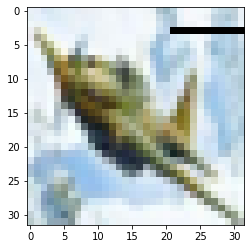

In [ ]:
patch_0_train, patch_1_train = add_patch(trainset, 7)

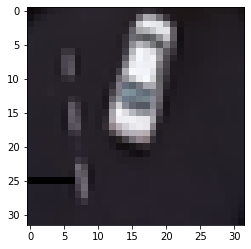

In [ ]:
plt.imshow(trainset.data[patch_1_train[100]], cmap='gray')

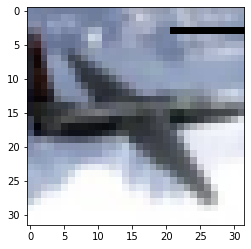

In [ ]:
patch_0_val, patch_1_val = add_patch(valset, 7)

In [ ]:
# Selecting classes 0 and 1
y_train = np.array(trainset.targets)
index = np.where(np.in1d(y_train, [0,1]))[0]
y_train = y_train[index]
trainset_01 = torch.utils.data.Subset(trainset, index)

y_val = np.array(valset.targets)
index = np.where(np.in1d(y_val, [0,1]))[0]
y_val = y_val[index]
valset_01 = torch.utils.data.Subset(valset, index)

train_loader = DataLoader(trainset_01, batch_size=args['batch_size'],
                                          shuffle=True, num_workers=2)

val_loader = DataLoader(valset_01, batch_size=args['batch_size'],
                                         shuffle=False, num_workers=2)

In [ ]:
#Instantiate the ReLU model
relu_model_with_patch = Relu(args['depth'], args['width'], args['input_shape'])
print(relu_model_with_patch)
print()

if args['cuda']:
    relu_model_with_patch.cuda()

optimizer = optim.Adam(relu_model_with_patch.parameters(), lr=args['lr'], eps=args['eps'])

for epoch in range(1, args['epochs'] + 1):
    train(relu_model_with_patch, epoch, train_loader, lossFn, optimizer)
    validate(relu_model_with_patch, val_loader, lossFn)

Relu(
  (L1): Linear(in_features=3072, out_features=64, bias=True)
  (L2): Linear(in_features=64, out_features=64, bias=True)
  (L3): Linear(in_features=64, out_features=64, bias=True)
  (L4): Linear(in_features=64, out_features=64, bias=True)
  (L5): Linear(in_features=64, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=1, bias=True)
)

Train Epoch: 1 	Loss: 0.016482, Accuracy: 7354/10000 (74%)

Validation set: Average loss: 0.0133, Accuracy: 1612/2000 (81%)

Train Epoch: 2 	Loss: 0.013499, Accuracy: 7980/10000 (80%)

Validation set: Average loss: 0.0131, Accuracy: 1590/2000 (80%)

Train Epoch: 3 	Loss: 0.012509, Accuracy: 8094/10000 (81%)

Validation set: Average loss: 0.0137, Accuracy: 1568/2000 (78%)

Train Epoch: 4 	Loss: 0.011170, Accuracy: 8381/10000 (84%)

Validation set: Average loss: 0.0144, Accuracy: 1555/2000 (78%)

Train Epoch: 5 	Loss: 0.009773, Accuracy: 8610/10000 (86%)

Validation set: Average loss: 0.0090, Accuracy: 1752/2000 (88%)

Train E

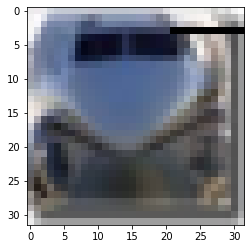

In [ ]:
plt.imshow(trainset_01.dataset.data[patch_0_train[100]])